# Adversarial Variational Optimization: PYTHIA Tuning

In this notebook Adversarial Variational Optimization (https://arxiv.org/abs/1707.07113) is applied to tuning parameters of a simplistic detector.

**Note: this notebook takes quite a long time to execute. It is recommended to run all cells at the beginning.**

**Please, don't interrupt the notebook while sampling from PythiaMill. Otherwise it might stuck at the next attempt to sample from it. IF this happens, please, restart the notebook.**

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm_notebook

import numpy as np

In [3]:
### don't forget about others!

import keras

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.2)
tf_session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

keras.backend.tensorflow_backend.set_session(tf_session)

Using TensorFlow backend.


## Generators

Pythia-mill is a python binding to Pythia generator that can run in multiple threads (processes).
For more details, please, visit https://github.com/maxim-borisyak/pythia-mill

In [4]:
import pythiamill as pm

SEED=123

### Note about the change of problem

The reason the detector parameters (instead of Pythia parameters) are the target for the tune is a purely technical one: on each step AVO requires samples from multiples configurations of generator + detector. However, Pythia requires about half of a second to be reconfigured, which induces a tremendous overhead.

By contrast, this simplistic detector is designed to accept its parameters as function arguments (effectively neglecting any overhead).


The detector emulates a $32 \times 32$ spherical uniform grid in `pseudorapidity` ($\eta$)-`angle in traverse plane` ($\phi$) covering $(\eta, \phi) \in [0, 5] \times [0, 2 \pi]$.

The detector is parametrized by offset in $z$-axis relative to the beam crossing point. Zero offset means that center of the sphere coincides with the collision point.

In [5]:
### ground truth offset, unknown in the real world problems.
TRUE_OFFSET=1

In [6]:
options = [
    ### telling pythia to be quiet.
    'Print:quiet = on',
    'Init:showProcesses = off',
    'Init:showMultipartonInteractions = off',
    'Init:showChangedSettings = off',
    'Init:showChangedParticleData = off',
    'Next:numberCount=0',
    'Next:numberShowInfo=0',
    'Next:numberShowEvent=0',
    'Stat:showProcessLevel=off',
    'Stat:showErrors=off',
    
    ### seeting default parameters to Monash values
    ### all options are taken from https://arxiv.org/abs/1610.08328
    "Tune:ee = 7",
    "Beams:idA = 11",
    "Beams:idB = -11",
    "Beams:eCM = 91.2",
    "WeakSingleBoson:ffbar2gmZ = on",
    "23:onMode = off",
    "23:onIfMatch = 1 -1",
    "23:onIfMatch = 2 -2",
    "23:onIfMatch = 3 -3",
    "23:onIfMatch = 4 -4",
    "23:onIfMatch = 5 -5",
]

In [7]:
### defining the detector
detector = pm.utils.SphericalTracker(
    ### with this option detector measures total energy
    ### of the particles traversing each pixel.
    is_binary=False,
    
    ### detector covers [0, 5] pseudo-rapidity range
    max_pseudorapidity=5.0,
    pseudorapidity_steps=32, phi_steps=32,
    ### 1 layer with radius 10 mm.
    n_layers=1, R_min=10.0, R_max=10.0,
)
    
mill = pm.ParametrizedPythiaMill(
    detector, options,
    ### please, don't use number of workers higher than 4.
    batch_size=8, n_workers=4,
    seed=SEED
)

In [8]:
def get_data(mill, detector_configurations, show_progress=False):
    """
    Utilitary function to obtain data for a particular set of configurations.
    
    :param mill: instance of Pythia Mill to sample from.
    : param detector configuration: - list of configurations.
        each configuration should be an array of detector parameters.
    : param show_progress: if True shows progress via `tqdm` package. 
    
    :return:
        - parameters: array of shape `<number of samples> x <parameters dim>`, parameters for each sample;
        - samples: array of shape `<number of samples> x 1 x 32 x 32`, sampled events.
    """
    try:
        ### sending requests to the queue
        for args in detector_configurations:
            mill.request(*args)

        ### retrieving results
        data = [
            mill.retrieve()
            for _ in (
                (lambda x: tqdm_notebook(x, postfix='data gen', leave=False))
                if show_progress else
                (lambda x: x)
            )(range(len(detector_configurations)))
        ]

        samples = np.vstack([ samples for params, samples in data ])
        params = np.vstack([ np.array([params] * samples.shape[0], dtype='float32') for params, samples in data ])

        return params, samples.reshape(-1, 32, 32, 1)
    finally:
        while mill.n_requests > 0:
            mill.retrieve()

In [9]:
### Generating training samples with ground truth parameters.
### For a real-world problem these arrays would correspond to real data.
_, X_true_train = get_data(mill, detector_configurations=[(TRUE_OFFSET, )] * 2 ** 12, show_progress=True)
_, X_true_val = get_data(mill, detector_configurations=[(TRUE_OFFSET, )] * 2 ** 12, show_progress=True)

In [10]:
print(X_true_train.shape)
print(X_true_val.shape)

(32768, 32, 32, 1)
(32768, 32, 32, 1)


### Taking a look at events

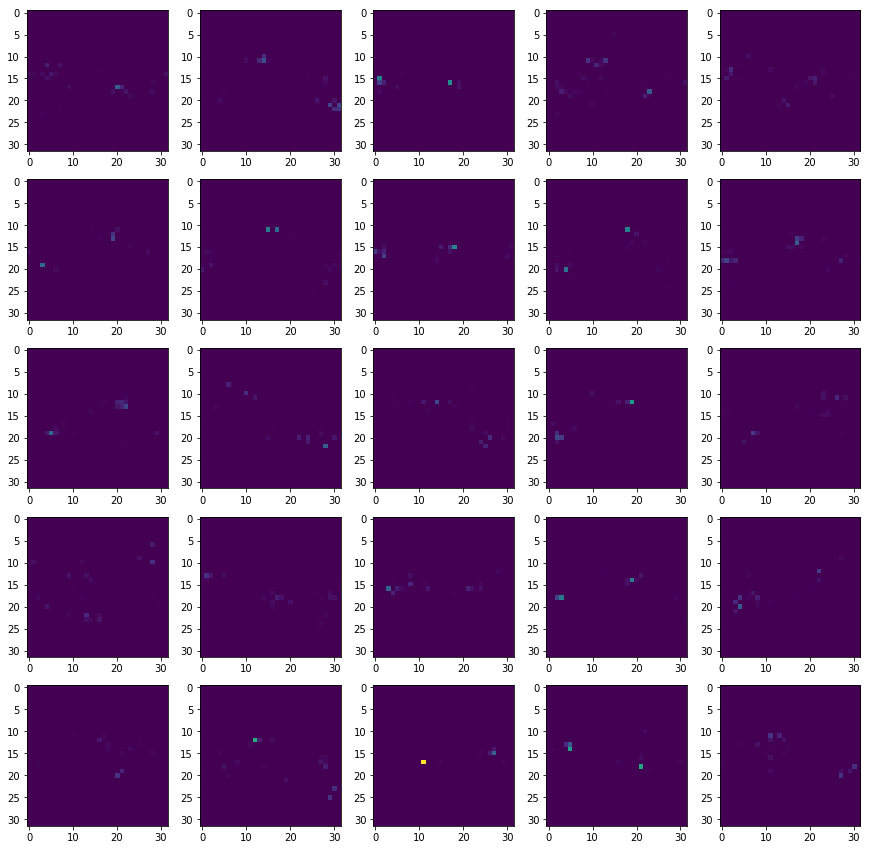

In [11]:
n = 5
plt.subplots(nrows=n, ncols=n, figsize=(3 * n, 3 * n))

max_energy = np.max(X_true_train[:n * n])

for i in range(n):
    for j in range(n):
        k = i * n + j
        plt.subplot(n, n, k + 1)
        plt.imshow(X_true_train[k, :, :, 0], vmin=0, vmax=max_energy)

plt.show()

### Aggregated events

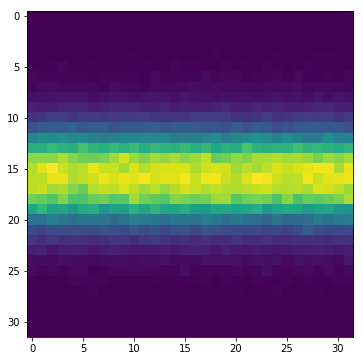

In [12]:
plt.figure(figsize=(6, 6))
plt.imshow(np.sum(X_true_train, axis=(0, 3)), vmin=0)
plt.show()

## Discriminator

In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, GlobalMaxPool2D
from keras.activations import softplus, sigmoid, relu

from keras.utils.vis_utils import model_to_dot

### Building conv net

In [14]:
inputs = Input(shape=(32, 32, 1))

activation = lambda x: relu(x, 0.05)

net = Conv2D(8, kernel_size=(3, 3), padding='same', activation=activation)(inputs)
net = MaxPool2D(pool_size=(2, 2))(net)

net = Conv2D(12, kernel_size=(3, 3), padding='same', activation=activation)(net)
net = MaxPool2D(pool_size=(2, 2))(net)
# net = GlobalMaxPool2D()(net)


net = Conv2D(16, kernel_size=(3, 3), padding='same', activation=activation)(net)
net = MaxPool2D(pool_size=(2, 2))(net)

net = Conv2D(24, kernel_size=(3, 3), padding='same', activation=activation)(net)
net = MaxPool2D(pool_size=(2, 2))(net)

net = Flatten()(net)
predictions = Dense(1, activation=sigmoid)(net)

discriminator = Model(inputs=inputs, outputs=predictions)

discriminator.compile(optimizer='adam', loss='binary_crossentropy')

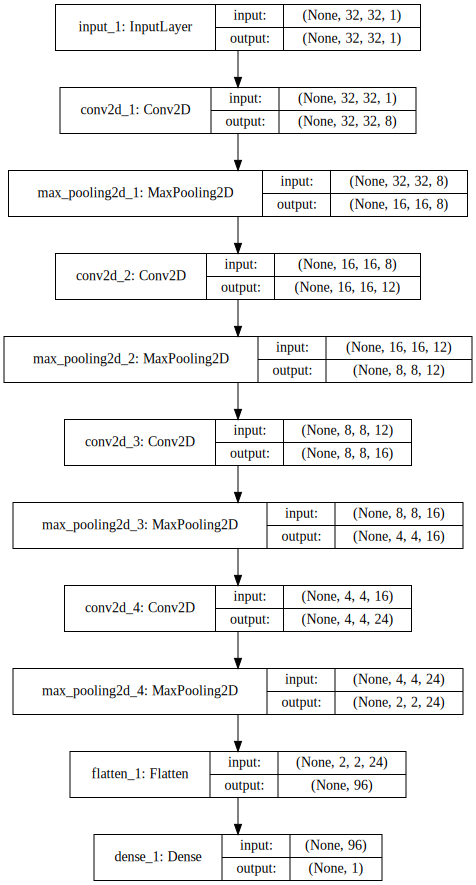

In [15]:
from IPython import display
from IPython.display import SVG

SVG(model_to_dot(discriminator, show_shapes=True).create(prog='dot', format='svg'))

In Adversarial Variational Optimization, instead of searching for a single value of detector parameters, a parametrized distribution is introduced (with parameters $\psi$):

$$\mathcal{L}(\psi) = \mathrm{JS}(X_\psi, X_\mathrm{data})$$
where:
- $X_\psi \sim \mathrm{detector}(\theta), \theta \sim P_\psi$;
- $X_\mathrm{data} \sim \mathrm{reality}$.

Note that $\mathcal{L}(\psi)$ is a vaiational bound on adversarial loss:

$$\mathcal{L}(\psi) \geq \min_\theta \mathcal{L}_\mathrm{adv}(\theta) = \mathrm{JS}(X_\theta, X_\mathrm{data})$$

In this example, detector parameters consist of a signle `offset` parameter. For simplicity normal distibution is used:

$$\mathrm{offset} \sim \mathcal{N}(\mu, \sigma)$$


In order to avoid introducing constraints $\sigma \geq 0$, an auxiliary *free variable* $\sigma'$ is introduced (denoted as `detector_params_sigma_raw` in the code):
$$\sigma = \log(1 + \exp(\sigma'))$$

Note that if there exists configuration of detector perfectly matching real data, then minimum of variational bound is achieved when the `offset` distribution collapses into delta function with the center at minumum of adversarial loss.
Otherwise, a mixture of detector configuations might be a solution (unlike convetional variational optimization).

In [16]:
X = tf.placeholder(dtype='float32', shape=(None, 32, 32, 1))

proba = discriminator(X)[:, 0]

detector_params = tf.placeholder(dtype='float32', shape=(None, 1))

detector_params_mean = tf.Variable(
    initial_value=np.array([0.0], dtype='float32'),
    dtype='float32'
)

detector_params_sigma_raw = tf.Variable(
    initial_value=np.array([2.0], dtype='float32'),
    dtype='float32'
)

detector_params_sigma = tf.nn.softplus(detector_params_sigma_raw)

neg_log_prob = tf.reduce_sum(
    tf.log(detector_params_sigma)
) + tf.reduce_sum(
    0.5 * (detector_params - detector_params_mean[None, :]) ** 2 / detector_params_sigma[None, :] ** 2
    , axis=1
)

detector_params_loss = tf.reduce_mean(neg_log_prob * proba)

In [17]:
get_distribution_params = lambda : tf_session.run([detector_params_mean, detector_params_sigma])

In [18]:
n = tf.placeholder(dtype='int64', shape=())
params_sample = tf.random_normal(
    mean=detector_params_mean,
    stddev=detector_params_sigma,
    shape=(n, 1),
    dtype='float32'
)

In [19]:
distribution_opt = tf.train.AdamOptimizer(learning_rate=0.02).minimize(
    detector_params_loss, var_list=[detector_params_mean, detector_params_sigma_raw]
)

In [20]:
tf_session.run(tf.global_variables_initializer())

In [21]:
def train_discriminator(n_samples=2 ** 16, n_epoches=16, plot=False):
    sample_of_detector_params = tf_session.run(params_sample, { n : n_samples // 8 })
    
    _, X_gen_train = get_data(
        mill,
        detector_configurations=sample_of_detector_params,
        show_progress=True
    )
    
    X_train = np.vstack([ X_gen_train, X_true_train ])
    y_train = np.hstack([ np.zeros(X_gen_train.shape[0]), np.ones(X_true_train.shape[0]) ]).astype('float32')
    
    history = discriminator.fit(x=X_train, y=y_train, batch_size=32, epochs=n_epoches, verbose=0)
    
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['loss'], label='train loss')
        plt.legend()
        plt.show()

In [22]:
def train_generator():
    sample_of_detector_params = tf_session.run(params_sample, { n : 2 ** 8 })
    params_train, X_gen_train = get_data(mill, detector_configurations=sample_of_detector_params)
    
    tf_session.run(
        distribution_opt,
        feed_dict={
            X : X_gen_train,
            detector_params : params_train
        }
    )

## Pretraining

AVO makes small changes in parameter distribution. When starting with the optimal discriminator from the previous iterations, adjusting discriminator to these changes should require relatively few optimization steps.

However, the initial discriminator state (which is just random weights), most probably, does not correspond to any optimal discriminator. Therefore, we pretrain discriminator in order to ensure that only a few epoches needed on each iteration to achieve an optimal discriminator.

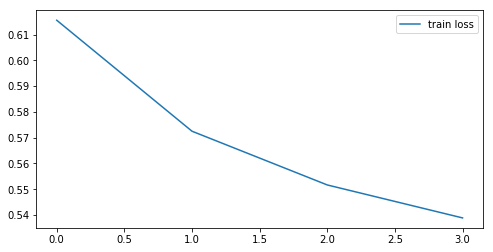

CPU times: user 2min, sys: 32.3 s, total: 2min 32s
Wall time: 1min 39s


In [23]:
%%time

train_discriminator(n_samples=2**16, n_epoches=4, plot=True)

## Variational optimization

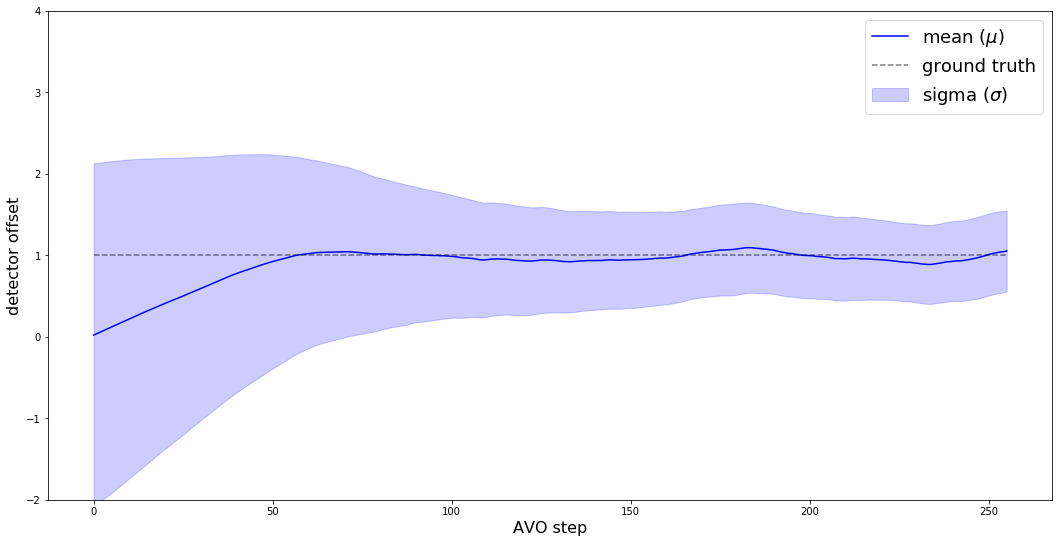

In [24]:
from IPython import display

n_iterations = 256

generator_mean_history = np.ndarray(shape=(n_iterations, ))
generator_sigma_history = np.ndarray(shape=(n_iterations, ))

for i in range(n_iterations):
    train_discriminator(n_samples=2**12, n_epoches=1)
    train_generator()
    
    m, s = get_distribution_params()
    generator_mean_history[i] = np.float32(m[0])
    generator_sigma_history[i] = np.float32(s[0])
    
    display.clear_output(wait=True)
    
    plt.figure(figsize=(18, 9))
    plt.plot(generator_mean_history[:i + 1], color='blue', label='mean ($\\mu$)')

    plt.fill_between(
        np.arange(i + 1),
        generator_mean_history[:i + 1] - generator_sigma_history[:i + 1],
        generator_mean_history[:i + 1] + generator_sigma_history[:i + 1],
        color='blue',
        label='sigma ($\\sigma$)',
        alpha=0.2
    )
    
    plt.plot([0, n_iterations - 1], [TRUE_OFFSET, TRUE_OFFSET], '--', color='black', alpha=0.5, label='ground truth')
    plt.ylim([-2, 4])
    plt.legend(loc='upper left', fontsize=18)
    plt.legend(fontsize=18)
    plt.xlabel('AVO step', fontsize=16)
    plt.ylabel('detector offset', fontsize=16)
    plt.show()